# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import yaml
import warnings

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, f1_score, accuracy_score

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

import joblib

#warnings.filterwarnings("ignore")

# Lecture du fichier data_cleaned_final_sans_dummies.csv

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

In [4]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'grav', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df[cat] = df[cat].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494181
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  int32  
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int32  
 6   int             447136 non-null  int32  
 7   atm             447136 non-null  int32  
 8   col             447136 non-null  int32  
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int32  
 12  circ            447136 non-null  int32  
 13  prof            447136 non-null  int32  
 14  plan            447136 non-null  int32  
 15  surf            447136 non-null  int32  
 16  infra           447136 non-null  int32  
 17  situ           

# Regroupement de modalités de 'grav' en 2 modalités : "tues" et "autres" 

In [5]:
# "indemnes (1) + blessés hospitalisés (3) + blessés légers (4)" => 0
df['grav'] = df['grav'].replace([1, 3, 4], 0)

# "tués (2)" => 1
df['grav'] = df['grav'].replace([2], 1)

df['grav'].unique()

array([0, 1])

# Séparation en train et test

Suppression des colonnes qui ne serviront pas pour la modélisation

In [6]:
df = df.drop(['an', 'jour', 'grav_rec', 'date', 'dep'], axis = 1)

Séparation des données de la cible

In [7]:
X = df.drop('grav', axis = 1)
y = df['grav']

y.value_counts(normalize = True)

grav
0    0.972713
1    0.027287
Name: proportion, dtype: float64

Séparation en train et test en gardant la même porportion de chque modalité de la cible dans les jeux d'entraînement et de test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

grav
0    0.972712
1    0.027288
Name: proportion, dtype: float64
grav
0    0.972715
1    0.027285
Name: proportion, dtype: float64


In [9]:
X_train.shape

(335352, 35)

# Création de train et test avec Oversampling et Undersampling

### Oversampling

Avec SMOTE

In [10]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
smo = SMOTENC(categorical_features = cat)
X_train_sm, y_train_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_train_sm).value_counts()))

Classes échantillon SMOTE : {0: 326201, 1: 326201}


Avec RandomOverSampler

In [11]:
rOs = RandomOverSampler()
X_train_ro, y_train_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_train_ro).value_counts()))

Classes échantillon oversampled : {0: 326201, 1: 326201}


### Undersampling

Avec RandomUnderSampler

In [12]:
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_train_ru).value_counts()))

Classes échantillon undersampled : {0: 9151, 1: 9151}


Avec ClusterCentroids

In [13]:
cc = ClusterCentroids()
X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon CC :', dict(pd.Series(y_train_cc).value_counts()))

Classes échantillon CC : {0: 9151, 1: 9151}


# Decision Tree

### Selection des variables

In [299]:
dt = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)

In [300]:
print("Train acuracy :", np.round(dt.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(dt.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = dt.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 100.0 %
Test acuracy :  95.11 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,105781,2953
1,2508,542



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.97      0.97    108734
           1       0.16      0.18      0.17      3050

    accuracy                           0.95    111784
   macro avg       0.57      0.58      0.57    111784
weighted avg       0.95      0.95      0.95    111784



Calcul de l'importance de chaque variable

In [301]:
importances_dt = pd.DataFrame({'feature':X_train.columns,'importance':np.round(dt.feature_importances_,3)})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(38)

,importance
feature,
lat,0.171
long,0.160
age_usager,0.127
heure,0.077
mois,0.066
place_rec,0.030
col,0.028
catr,0.025
situ,0.021


In [302]:
importances_dt.shape

(35, 1)

Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [303]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_dt), 1):
    liste_var = importances_dt.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    dt_2 = DecisionTreeClassifier(random_state = 42).fit(X_train_2, y_train)

    score = dt_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_dt = pd.DataFrame(dico)
y_pred_tableau_dt = y_pred_tableau_dt.sort_values(by = 'scores', ascending = False)
y_pred_tableau_dt.head(5)

,nombre_variable,scores
0,1,0.960844
1,2,0.958957
29,30,0.951317
30,31,0.951102
31,32,0.950995


In [304]:
nb_variable_dt = y_pred_tableau_dt.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_dt, 'variables')

La meilleur accuracy est obtenue avec 1.0 variables


In [305]:
meilleurs_variables_dt = importances_dt.index[0 : int(nb_variable_dt)]
meilleurs_variables_dt

Index(['lat'], dtype='object', name='feature')

In [306]:
liste_var = importances_dt.index[0 : int(nb_variable_dt)]
X_train_dt = X_train[liste_var]
X_test_dt = X_test[liste_var]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_dt, y_train)

In [307]:
print("Train acuracy :", np.round(dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 98.38 %
Test acuracy :  96.08 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,107276,1458
1,2919,131



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    108734
           1       0.08      0.04      0.06      3050

    accuracy                           0.96    111784
   macro avg       0.53      0.51      0.52    111784
weighted avg       0.95      0.96      0.95    111784



### Hyperparamétrage

In [29]:
liste_var_dt = ['lat']
X_train_dt = X_train[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_dt, y_train)

##### Avec class_weight = None

In [309]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [310]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.972322
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.972685
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.972319
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.972694
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.972360
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.972712
140  {'class_weight': None, 'criterion': 'entropy',...         0.972712
141  {'class_weight': None, 'criterion': 'entropy',...         0.972712
142  {'class_weight': None, 'criterion': 'entropy',...         0.972712
143  {'class_weight': None, 'criterion': 'entropy',...         0.972712

[144 rows x 2 columns]


In [311]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'random_state': 42, 'splitter': 'random'}
0.9727182185297399


In [312]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 97.27 %
Test acuracy :  97.27 %

Matrice de confusion :


Classes prédites,0
Classes réelles,
0,108734
1,3050



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.00      0.00      0.00      3050

    accuracy                           0.97    111784
   macro avg       0.49      0.50      0.49    111784
weighted avg       0.95      0.97      0.96    111784



/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Recherche du meilleur max_depth

In [104]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['random'],
            'max_depth' : [2, 4, 6, 8, 10, 12, 14],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced']
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [105]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
0.46010318479301715


In [106]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 73.68 %
Test acuracy :  73.88 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,81433,27301
1,1892,1158



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.75      0.85    108734
           1       0.04      0.38      0.07      3050

    accuracy                           0.74    111784
   macro avg       0.51      0.56      0.46    111784
weighted avg       0.95      0.74      0.83    111784



##### Avec class_weight = 'balanced'

In [555]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced']
            }

In [556]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': 'balanced', 'criterion': 'gin...         0.554391
1    {'class_weight': 'balanced', 'criterion': 'gin...         0.593377
2    {'class_weight': 'balanced', 'criterion': 'gin...         0.554265
3    {'class_weight': 'balanced', 'criterion': 'gin...         0.509596
4    {'class_weight': 'balanced', 'criterion': 'gin...         0.553839
..                                                 ...              ...
139  {'class_weight': 'balanced', 'criterion': 'ent...         0.514003
140  {'class_weight': 'balanced', 'criterion': 'ent...         0.654333
141  {'class_weight': 'balanced', 'criterion': 'ent...         0.514003
142  {'class_weight': 'balanced', 'criterion': 'ent...         0.654333
143  {'class_weight': 'balanced', 'criterion': 'ent...         0.514003

[144 rows x 2 columns]


In [557]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
0.9383990513963407


In [558]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()

y_pred = grid_dt.predict(X_test_dt)

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 96.84 %
Test acuracy :  93.64 %



0.9363951907249696
Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,104302,4432
1,2678,372



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.96      0.97    108734
           1       0.08      0.12      0.09      3050

    accuracy                           0.94    111784
   macro avg       0.53      0.54      0.53    111784
weighted avg       0.95      0.94      0.94    111784



Sélection du meilleur max_depth

In [107]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['random'],
            'max_depth' : [20, 25, 30, 35, 40, 45, 50, 55, 60],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : ['balanced']
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [108]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}
0.5311303782381852


In [109]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 96.84 %
Test acuracy :  93.64 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,104302,4432
1,2678,372



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      0.96      0.97    108734
           1       0.08      0.12      0.09      3050

    accuracy                           0.94    111784
   macro avg       0.53      0.54      0.53    111784
weighted avg       0.95      0.94      0.94    111784



##### Recherche du meilleur class_weight

In [15]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30],
            'max_features' : [None],
            'random_state' : [42],
            'class_weight' : [{0:1, 1:18}]
            }

In [16]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_dt, y_train)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.878528
1    {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.914886
2    {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.878376
3    {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.905526
4    {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.877916
..                                                 ...              ...
139  {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.858775
140  {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.770128
141  {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.858775
142  {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.770128
143  {'class_weight': {0: 1, 1: 18}, 'criterion': '...         0.858775

[144 rows x 2 columns]


In [17]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': {0: 1, 1: 18}, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.9385123648658185


In [18]:
print("Train acuracy :", np.round(grid_dt.score(X_train_dt, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 96.89 %
Test acuracy :  93.65 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,104311,4423
1,2672,378



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    108734
           1       0.08      0.12      0.10      3050

    accuracy                           0.94    111784
   macro avg       0.53      0.54      0.53    111784
weighted avg       0.95      0.94      0.94    111784



Sélection du meilleur max_depth

In [110]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1],
            'max_features' : [None],
            'random_state' : [42],
            'class_weight' : [{0:1, 1:18}]
            } 

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_dt, y_train)

In [111]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': {0: 1, 1: 18}, 'criterion': 'gini', 'max_depth': 90, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.5312025228635165


In [112]:
y_train_pred = grid_dt_2.predict(X_train_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 96.89 %
Test acuracy :  93.65 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,92272,16462
1,845,2205



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    108734
           1       0.08      0.12      0.10      3050

    accuracy                           0.94    111784
   macro avg       0.53      0.54      0.53    111784
weighted avg       0.95      0.94      0.94    111784



##### Avec SMOTENC

In [113]:
liste_var_dt = ['lat']
X_train_sm_dt = X_train_sm[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_sm_dt, y_train_sm)

In [322]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [323]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_sm_dt, y_train_sm)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.699166
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.674520
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.699141
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.672774
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.699098
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.692440
140  {'class_weight': None, 'criterion': 'entropy',...         0.701860
141  {'class_weight': None, 'criterion': 'entropy',...         0.692440
142  {'class_weight': None, 'criterion': 'entropy',...         0.701860
143  {'class_weight': None, 'criterion': 'entropy',...         0.692440

[144 rows x 2 columns]


In [324]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7705617258871976


In [325]:
print("Train acuracy :", np.round(grid_dt.score(X_train_sm_dt, y_train_sm) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 95.84 %
Test acuracy :  86.79 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,96188,12546
1,2219,831



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.88      0.93    108734
           1       0.06      0.27      0.10      3050

    accuracy                           0.87    111784
   macro avg       0.52      0.58      0.51    111784
weighted avg       0.95      0.87      0.91    111784



Sélection du meilleur max_depth

In [114]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [20, 30, 40, 50, 60, 70, 80, 90, 100],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }   

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_sm_dt, y_train_sm)

In [115]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.7684715568615479


In [116]:
y_train_pred = grid_dt_2.predict(X_train_sm_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_sm, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 95.85 %
Test acuracy :  86.91 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,96285,12449
1,2182,868



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.89      0.93    108734
           1       0.07      0.28      0.11      3050

    accuracy                           0.87    111784
   macro avg       0.52      0.59      0.52    111784
weighted avg       0.95      0.87      0.91    111784



##### Avec RandomOverSampler

In [117]:
liste_var_dt = ['lat']
X_train_ro_dt = X_train_ro[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_ro_dt, y_train_ro)

In [327]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [328]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_ro_dt, y_train_ro)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.661361
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.624048
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.661361
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.624048
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.661361
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.649075
140  {'class_weight': None, 'criterion': 'entropy',...         0.857067
141  {'class_weight': None, 'criterion': 'entropy',...         0.649075
142  {'class_weight': None, 'criterion': 'entropy',...         0.857067
143  {'class_weight': None, 'criterion': 'entropy',...         0.649075

[144 rows x 2 columns]


In [329]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.9763121508429469


In [330]:
print("Train acuracy :", np.round(grid_dt.score(X_train_ro_dt, y_train_ro) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 98.38 %
Test acuracy :  93.61 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,104261,4473
1,2670,380



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    108734
           1       0.08      0.12      0.10      3050

    accuracy                           0.94    111784
   macro avg       0.53      0.54      0.53    111784
weighted avg       0.95      0.94      0.94    111784



Sélection du meilleur max_depth

In [118]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }  

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_ro_dt, y_train_ro)

In [119]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.9762773923456951


In [120]:
y_train_pred = grid_dt_2.predict(X_train_ro_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_ro, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 98.38 %
Test acuracy :  93.61 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,104261,4473
1,2670,380



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    108734
           1       0.08      0.12      0.10      3050

    accuracy                           0.94    111784
   macro avg       0.53      0.54      0.53    111784
weighted avg       0.95      0.94      0.94    111784



##### Avec RandomUnderSampler

In [121]:
liste_var_dt = ['lat']
X_train_ru_dt = X_train_ru[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_ru_dt, y_train_ru)

In [332]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None]
            }

In [333]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_ru_dt, y_train_ru)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.625451
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.610371
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.624522
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.610424
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.624195
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.612556
140  {'class_weight': None, 'criterion': 'entropy',...         0.617200
141  {'class_weight': None, 'criterion': 'entropy',...         0.612556
142  {'class_weight': None, 'criterion': 'entropy',...         0.617200
143  {'class_weight': None, 'criterion': 'entropy',...         0.612556

[144 rows x 2 columns]


In [334]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6254512264110107


In [335]:
print("Train acuracy :", np.round(grid_dt.score(X_train_ru_dt, y_train_ru) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 67.39 %
Test acuracy :  53.38 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,57496,51238
1,877,2173



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.53      0.69    108734
           1       0.04      0.71      0.08      3050

    accuracy                           0.53    111784
   macro avg       0.51      0.62      0.38    111784
weighted avg       0.96      0.53      0.67    111784



Recherche du meilleur max_depth

In [122]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [1], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None]}  

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_ru_dt, y_train_ru)

In [123]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6161355401335019


In [124]:
y_train_pred = grid_dt_2.predict(X_train_ru_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_ru, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 73.7 %
Test acuracy :  56.76 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,61459,47275
1,1061,1989



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.57      0.72    108734
           1       0.04      0.65      0.08      3050

    accuracy                           0.57    111784
   macro avg       0.51      0.61      0.40    111784
weighted avg       0.96      0.57      0.70    111784



##### Avec ClusterCentroids

In [125]:
liste_var_dt = ['lat']
X_train_cc_dt = X_train_cc[liste_var_dt]
X_test_dt = X_test[liste_var_dt]

dt = DecisionTreeClassifier(random_state = 42).fit(X_train_cc_dt, y_train_cc)

In [337]:
params_dt = {'criterion' : ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20], 
            'min_samples_leaf' : [1, 10, 20, 30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None],
            }

In [338]:
grid_dt = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5).fit(X_train_cc_dt, y_train_cc)
print(pd.DataFrame.from_dict(grid_dt.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'class_weight': None, 'criterion': 'gini', 'm...         0.675772
1    {'class_weight': None, 'criterion': 'gini', 'm...         0.672603
2    {'class_weight': None, 'criterion': 'gini', 'm...         0.675882
3    {'class_weight': None, 'criterion': 'gini', 'm...         0.670745
4    {'class_weight': None, 'criterion': 'gini', 'm...         0.676537
..                                                 ...              ...
139  {'class_weight': None, 'criterion': 'entropy',...         0.627041
140  {'class_weight': None, 'criterion': 'entropy',...         0.660637
141  {'class_weight': None, 'criterion': 'entropy',...         0.627041
142  {'class_weight': None, 'criterion': 'entropy',...         0.660637
143  {'class_weight': None, 'criterion': 'entropy',...         0.627041

[144 rows x 2 columns]


In [339]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6771383792836321


In [340]:
print("Train acuracy :", np.round(grid_dt.score(X_train_cc_dt, y_train_cc) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_dt.score(X_test_dt, y_test) * 100, 2), "%")
print()
y_pred = grid_dt.predict(X_test_dt)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 69.72 %
Test acuracy :  50.58 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54635,54099
1,1140,1910



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.50      0.66    108734
           1       0.03      0.63      0.06      3050

    accuracy                           0.51    111784
   macro avg       0.51      0.56      0.36    111784
weighted avg       0.95      0.51      0.65    111784



Recherche du meilleur max_depth

In [126]:
params_dt = {'criterion' : ['gini'],
            'splitter' : ['best'],
            'max_depth' : [2, 4, 6, 8, 10, 12, 14, 16, 18],
            'min_samples_split' : [2], 
            'min_samples_leaf' : [30], 
            'max_features' : ['sqrt'],
            'random_state' : [42],
            'class_weight' : [None]
            }

grid_dt_2 = GridSearchCV(estimator = dt, param_grid = params_dt, cv = 5, scoring = 'f1_macro').fit(X_train_cc_dt, y_train_cc)

In [127]:
print(grid_dt_2.best_params_)
print(grid_dt_2.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 30, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
0.6688687069801798


In [128]:
y_train_pred = grid_dt_2.predict(X_train_cc_dt)
y_test_pred = grid_dt_2.predict(X_test_dt)
print("Train acuracy :", np.round(accuracy_score(y_train_cc, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 68.97 %
Test acuracy :  50.91 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,54989,53745
1,1135,1915



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.51      0.67    108734
           1       0.03      0.63      0.07      3050

    accuracy                           0.51    111784
   macro avg       0.51      0.57      0.37    111784
weighted avg       0.95      0.51      0.65    111784



# Random Forest

### Selection des variables

In [341]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

In [342]:
print("Train acuracy :", np.round(rf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.99 %
Test acuracy :  97.28 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,108663,71
1,2970,80



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.53      0.03      0.05      3050

    accuracy                           0.97    111784
   macro avg       0.75      0.51      0.52    111784
weighted avg       0.96      0.97      0.96    111784



In [343]:
importances_rf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(38)

,importance
feature,
age_usager,0.135
lat,0.132
long,0.131
heure,0.086
mois,0.069
col,0.032
catr,0.030
lum,0.025
place_rec,0.024


Recherche du nombre de variables permettant d'obtenir la meilleur accuracy

In [344]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_rf), 1):
    liste_var = importances_rf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    rf_2 = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = rf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_rf = pd.DataFrame(dico)
y_pred_tableau_rf = y_pred_tableau_rf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_rf.head(5)

,nombre_variable,scores
33,34,0.972885
32,33,0.972876
30,31,0.972867
31,32,0.972796
27,28,0.972787


In [345]:
nb_variable_rf = y_pred_tableau_rf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_rf, 'variables')

La meilleur accuracy est obtenue avec 34.0 variables


In [346]:
meilleurs_variables_rf = importances_rf.index[0 : int(nb_variable_rf)]
meilleurs_variables_rf

Index(['age_usager', 'lat', 'long', 'heure', 'mois', 'col', 'catr', 'lum',
       'place_rec', 'manv', 'situ', 'weekend', 'infra', 'surf', 'prof', 'plan',
       'motor', 'jour_chome', 'catv', 'agg', 'sexe', 'atm', 'eq_ceinture',
       'obsm', 'eq_indetermine', 'obs', 'int', 'prox_pt_choc', 'circ',
       'eq_casque', 'eq_gants', 'eq_autre', 'eq_airbag', 'eq_siege'],
      dtype='object', name='feature')

In [347]:
liste_var = importances_rf.index[0 : int(nb_variable_rf)]
X_train_rf = X_train[liste_var]
X_test_rf = X_test[liste_var]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

In [348]:
print("Train acuracy :", np.round(rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.99 %
Test acuracy :  97.29 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,108671,63
1,2968,82



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.57      0.03      0.05      3050

    accuracy                           0.97    111784
   macro avg       0.77      0.51      0.52    111784
weighted avg       0.96      0.97      0.96    111784



### Hyperparamétrage

In [10]:
liste_var_rf = ['age_usager', 'lat', 'long', 'heure', 'mois', 'col', 'catr', 'lum',
       'place_rec', 'manv', 'situ', 'weekend', 'infra', 'surf', 'prof', 'plan',
       'motor', 'jour_chome', 'catv', 'agg', 'sexe', 'atm', 'eq_ceinture',
       'obsm', 'eq_indetermine', 'obs', 'int', 'prox_pt_choc', 'circ',
       'eq_casque', 'eq_gants', 'eq_autre', 'eq_airbag', 'eq_siege']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_rf, y_train)

##### Avec class_weight = None

In [350]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}   

In [351]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.972736
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.972733
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.972733
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.972727
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.972727
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.972745
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.972745
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.972724
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.972724
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.972724

[108 rows x 2 columns]


In [352]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.97291502658858


In [353]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 98.0 %
Test acuracy :  97.29 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,108698,36
1,2998,52



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.59      0.02      0.03      3050

    accuracy                           0.97    111784
   macro avg       0.78      0.51      0.51    111784
weighted avg       0.96      0.97      0.96    111784



Recherche du meilleur max_depth

In [129]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 15, 20, 25],
             'min_samples_split' : [10],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [130]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.5096340087990521


In [133]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 98.0 %
Test acuracy :  97.29 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,108698,36
1,2998,52



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.59      0.02      0.03      3050

    accuracy                           0.97    111784
   macro avg       0.78      0.51      0.51    111784
weighted avg       0.96      0.97      0.96    111784



##### Avec class_weight = 'balanced'

In [43]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20, None],
            'min_samples_split' : [2, 10, 20],
            'min_samples_leaf' : [1, 10, 20],
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}    

In [44]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': 'balanced...         0.806138
1    {'bootstrap': False, 'class_weight': 'balanced...         0.805047
2    {'bootstrap': False, 'class_weight': 'balanced...         0.804742
3    {'bootstrap': False, 'class_weight': 'balanced...         0.803666
4    {'bootstrap': False, 'class_weight': 'balanced...         0.803666
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': 'balanced'...         0.937138
104  {'bootstrap': True, 'class_weight': 'balanced'...         0.937138
105  {'bootstrap': True, 'class_weight': 'balanced'...         0.898727
106  {'bootstrap': True, 'class_weight': 'balanced'...         0.898727
107  {'bootstrap': True, 'class_weight': 'balanced'...         0.898727

[108 rows x 2 columns]


In [45]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9726705077169026


In [46]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.99 %
Test acuracy :  97.28 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,108672,62
1,2983,67



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.52      0.02      0.04      3050

    accuracy                           0.97    111784
   macro avg       0.75      0.51      0.51    111784
weighted avg       0.96      0.97      0.96    111784



Recherche du meilleur max_depth

In [134]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['entropy'],
            'max_depth' : [10, 15, 20, 25],
            'min_samples_split' : [2],
            'min_samples_leaf' : [1],
            'bootstrap' : [True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : ['balanced']}    

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [135]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.5928219614112008


In [137]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 91.97 %
Test acuracy :  90.47 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,99520,9214
1,1435,1615



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.92      0.95    108734
           1       0.15      0.53      0.23      3050

    accuracy                           0.90    111784
   macro avg       0.57      0.72      0.59    111784
weighted avg       0.96      0.90      0.93    111784



##### Recherche du meilleur class_weight

In [358]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [10, 20,  None],
            'min_samples_split' : [2, 10, 20],
            'min_samples_leaf' : [1, 10, 20],
            'bootstrap' : [False, True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{0:1, 1:18}]} 

In [359]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_rf, y_train)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.892188
1   {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.958849
2   {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.972241
3   {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.891517
4   {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.958536
5   {'bootstrap': False, 'class_weight': {0: 1, 1:...         0.972298
6   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.903066
7   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.966009
8   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.972635
9   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.900913
10  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.965982
11  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.972641


In [360]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': {0: 1, 1: 18}, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9726406884811087


In [361]:
print("Train acuracy :", np.round(grid_rf.score(X_train_rf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.99 %
Test acuracy :  97.27 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,108668,66
1,2981,69



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.51      0.02      0.04      3050

    accuracy                           0.97    111784
   macro avg       0.74      0.51      0.51    111784
weighted avg       0.96      0.97      0.96    111784



Recherche du meilleur max_depth

In [138]:
params_rf = {'n_estimators' : [100],
            'criterion' : ['entropy'],
            'max_depth' : [10, 15, 25, 25, 30, 35],
            'min_samples_split' : [2],
            'min_samples_leaf' : [1],
            'bootstrap' : [True],
            'n_jobs' : [-1],
            'random_state' : [42],
            'class_weight' : [{0:1, 1:18}]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_rf, y_train)

In [139]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': True, 'class_weight': {0: 1, 1: 18}, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.6095215740568148


In [140]:
y_train_pred = grid_rf_2.predict(X_train_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 95.35 %
Test acuracy :  93.77 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,103652,5082
1,1882,1168



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.95      0.97    108734
           1       0.19      0.38      0.25      3050

    accuracy                           0.94    111784
   macro avg       0.58      0.67      0.61    111784
weighted avg       0.96      0.94      0.95    111784



##### Avec SMOTE

In [141]:
liste_var_rf = ['age_usager', 'lat', 'long', 'heure', 'mois', 'col', 'catr', 'lum',
       'place_rec', 'manv', 'situ', 'weekend', 'infra', 'surf', 'prof', 'plan',
       'motor', 'jour_chome', 'catv', 'agg', 'sexe', 'atm', 'eq_ceinture',
       'obsm', 'eq_indetermine', 'obs', 'int', 'prox_pt_choc', 'circ',
       'eq_casque', 'eq_gants', 'eq_autre', 'eq_airbag', 'eq_siege']
X_train_sm_rf = X_train_sm[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_sm_rf, y_train_sm)

In [363]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]} 

In [364]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_sm_rf, y_train_sm)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.868619
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.868903
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.868422
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.868094
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.868094
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.944004
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.944004
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.929663
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.929663
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.929663

[108 rows x 2 columns]


In [365]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9757496481055279


In [366]:
print("Train acuracy :", np.round(grid_rf.score(X_train_sm_rf, y_train_sm) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 100.0 %
Test acuracy :  95.52 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,106131,2603
1,2404,646



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    108734
           1       0.20      0.21      0.21      3050

    accuracy                           0.96    111784
   macro avg       0.59      0.59      0.59    111784
weighted avg       0.96      0.96      0.96    111784



Recherche du meilleur max_depth

In [197]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [20, 30, 40, 50, 60, 70, 80, 90, 100],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_sm_rf, y_train_sm)

In [198]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9757455804059145


In [199]:
y_train_pred = grid_rf_2.predict(X_train_sm_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_sm, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 100.0 %
Test acuracy :  95.53 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,106115,2619
1,2381,669



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    108734
           1       0.20      0.22      0.21      3050

    accuracy                           0.96    111784
   macro avg       0.59      0.60      0.59    111784
weighted avg       0.96      0.96      0.96    111784



##### Avec RandomOverSampler

In [148]:
liste_var_rf = ['age_usager', 'lat', 'long', 'heure', 'mois', 'col', 'catr', 'lum',
       'place_rec', 'manv', 'situ', 'weekend', 'infra', 'surf', 'prof', 'plan',
       'motor', 'jour_chome', 'catv', 'agg', 'sexe', 'atm', 'eq_ceinture',
       'obsm', 'eq_indetermine', 'obs', 'int', 'prox_pt_choc', 'circ',
       'eq_casque', 'eq_gants', 'eq_autre', 'eq_airbag', 'eq_siege']
X_train_ro_rf = X_train_ro[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_ro_rf, y_train_ro)

In [368]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [369]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_ro_rf, y_train_ro)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.834867
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.834867
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.834815
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.833552
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.833552
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.971614
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.971614
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.952233
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.952233
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.952233

[108 rows x 2 columns]


In [370]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9991033137420784


In [371]:
print("Train acuracy :", np.round(grid_rf.score(X_train_ro_rf, y_train_ro) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 100.0 %
Test acuracy :  97.25 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,108601,133
1,2945,105



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.44      0.03      0.06      3050

    accuracy                           0.97    111784
   macro avg       0.71      0.52      0.52    111784
weighted avg       0.96      0.97      0.96    111784



Recherche du meilleur max_depth

In [188]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [20, 30, 40, 50, 60, 70],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]} 

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_ro_rf, y_train_ro)

In [189]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.999135501828898


In [190]:
y_train_pred = grid_rf_2.predict(X_train_ro_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_ro, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 100.0 %
Test acuracy :  97.24 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,108598,136
1,2950,100



Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    108734
           1       0.42      0.03      0.06      3050

    accuracy                           0.97    111784
   macro avg       0.70      0.52      0.52    111784
weighted avg       0.96      0.97      0.96    111784



##### Avec RandomUnderSampler

In [152]:
liste_var_rf = ['age_usager', 'lat', 'long', 'heure', 'mois', 'col', 'catr', 'lum',
       'place_rec', 'manv', 'situ', 'weekend', 'infra', 'surf', 'prof', 'plan',
       'motor', 'jour_chome', 'catv', 'agg', 'sexe', 'atm', 'eq_ceinture',
       'obsm', 'eq_indetermine', 'obs', 'int', 'prox_pt_choc', 'circ',
       'eq_casque', 'eq_gants', 'eq_autre', 'eq_airbag', 'eq_siege']
X_train_ru_rf = X_train_ru[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_ru_rf, y_train_ru)

In [373]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [374]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_ru_rf, y_train_ru)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.795104
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.796580
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.796361
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.796088
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.796088
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.797017
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.797017
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.794613
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.794613
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.794613

[108 rows x 2 columns]


In [375]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8036282302156985


In [376]:
print("Train acuracy :", np.round(grid_rf.score(X_train_ru_rf, y_train_ru) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 99.01 %
Test acuracy :  77.65 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,84238,24496
1,485,2565



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.77      0.87    108734
           1       0.09      0.84      0.17      3050

    accuracy                           0.78    111784
   macro avg       0.54      0.81      0.52    111784
weighted avg       0.97      0.78      0.85    111784



Recherche du meilleur max_depth

In [173]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [20, 25, 30, 35, 40, 45],
             'min_samples_split' : [10],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_ru_rf, y_train_ru)

In [174]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.8068906775656938


In [175]:
y_train_pred = grid_rf_2.predict(X_train_ru_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_ru, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 98.92 %
Test acuracy :  77.62 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,84190,24544
1,478,2572



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.77      0.87    108734
           1       0.09      0.84      0.17      3050

    accuracy                           0.78    111784
   macro avg       0.54      0.81      0.52    111784
weighted avg       0.97      0.78      0.85    111784



##### Avec ClusterCentroids

In [156]:
liste_var_rf = ['age_usager', 'lat', 'long', 'heure', 'mois', 'col', 'catr', 'lum',
       'place_rec', 'manv', 'situ', 'weekend', 'infra', 'surf', 'prof', 'plan',
       'motor', 'jour_chome', 'catv', 'agg', 'sexe', 'atm', 'eq_ceinture',
       'obsm', 'eq_indetermine', 'obs', 'int', 'prox_pt_choc', 'circ',
       'eq_casque', 'eq_gants', 'eq_autre', 'eq_airbag', 'eq_siege']
X_train_cc_rf = X_train_cc[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

rf = RandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_cc_rf, y_train_cc)

In [378]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [10, 20,  None],
             'min_samples_split' : [2, 10, 20],
             'min_samples_leaf' : [1, 10, 20],
             'bootstrap' : [False, True],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

In [379]:
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5).fit(X_train_cc_rf, y_train_cc)
print(pd.DataFrame.from_dict(grid_rf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                                params  mean_test_score
0    {'bootstrap': False, 'class_weight': None, 'cr...         0.993006
1    {'bootstrap': False, 'class_weight': None, 'cr...         0.992350
2    {'bootstrap': False, 'class_weight': None, 'cr...         0.992077
3    {'bootstrap': False, 'class_weight': None, 'cr...         0.991859
4    {'bootstrap': False, 'class_weight': None, 'cr...         0.991859
..                                                 ...              ...
103  {'bootstrap': True, 'class_weight': None, 'cri...         0.991585
104  {'bootstrap': True, 'class_weight': None, 'cri...         0.991585
105  {'bootstrap': True, 'class_weight': None, 'cri...         0.990383
106  {'bootstrap': True, 'class_weight': None, 'cri...         0.990383
107  {'bootstrap': True, 'class_weight': None, 'cri...         0.990383

[108 rows x 2 columns]


In [380]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9939348590892333


In [381]:
print("Train acuracy :", np.round(grid_rf.score(X_train_cc_rf, y_train_cc) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_rf.score(X_test_rf, y_test) * 100, 2), "%")
print()
y_pred = grid_rf.predict(X_test_rf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 100.0 %
Test acuracy :  3.22 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,551,108183
1,4,3046



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.01      0.01    108734
           1       0.03      1.00      0.05      3050

    accuracy                           0.03    111784
   macro avg       0.51      0.50      0.03    111784
weighted avg       0.97      0.03      0.01    111784



Recherche du meilleur max_depth

In [157]:
params_rf = {'n_estimators' : [100],
             'criterion' : ['gini'],
             'max_depth' : [10, 12, 14, 16, 18, 20, 22],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'bootstrap' : [False],
             'n_jobs' : [-1],
             'random_state' : [42],
             'class_weight' : [None]}  

grid_rf_2 = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, scoring = 'f1_macro').fit(X_train_cc_rf, y_train_cc)

In [158]:
print(grid_rf_2.best_params_)
print(grid_rf_2.best_score_)

{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
0.9941531674248463


In [159]:
y_train_pred = grid_rf_2.predict(X_train_cc_rf)
y_test_pred = grid_rf_2.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train_cc, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 100.0 %
Test acuracy :  3.17 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,495,108239
1,3,3047



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.00      0.01    108734
           1       0.03      1.00      0.05      3050

    accuracy                           0.03    111784
   macro avg       0.51      0.50      0.03    111784
weighted avg       0.97      0.03      0.01    111784



# Balanced Random Forest

### Selection des variables

In [382]:
brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

In [383]:
print("Train acuracy :", np.round(brf.score(X_train, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(brf.score(X_test, y_test) * 100, 2), "%")
print()
y_pred = brf.predict(X_test)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 78.9 %
Test acuracy :  77.9 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,84508,24226
1,474,2576



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.78      0.87    108734
           1       0.10      0.84      0.17      3050

    accuracy                           0.78    111784
   macro avg       0.55      0.81      0.52    111784
weighted avg       0.97      0.78      0.85    111784



In [384]:
importances_brf = pd.DataFrame({'feature':X_train.columns,'importance':np.round(brf.feature_importances_,3)})
importances_brf = importances_brf.sort_values('importance',ascending=False).set_index('feature')
importances_brf.head(38)

,importance
feature,
age_usager,0.107
lat,0.093
long,0.083
heure,0.061
col,0.061
agg,0.058
eq_ceinture,0.049
mois,0.047
catr,0.046


In [385]:
nombre_variable = []
scores = []

for i in np.arange(1, len(importances_brf), 1):
    liste_var = importances_brf.index[0 : i]
    X_train_2 = X_train[liste_var]
    X_test_2 = X_test[liste_var]

    brf_2 = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_2, y_train)

    score = brf_2.score(X_test_2, y_test)
    
    nombre_variable.append(i)
    scores.append(score)
 
dico = {'nombre_variable' : nombre_variable,
        'scores' : scores}   

y_pred_tableau_brf = pd.DataFrame(dico)
y_pred_tableau_brf = y_pred_tableau_brf.sort_values(by = 'scores', ascending = False)
y_pred_tableau_brf.head(5)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

,nombre_variable,scores
24,25,0.780514
28,29,0.780335
23,24,0.780255
32,33,0.780130
30,31,0.779960


In [386]:
nb_variable_brf = y_pred_tableau_brf.iloc[0]['nombre_variable']
print("La meilleur accuracy est obtenue avec", nb_variable_brf, 'variables')

La meilleur accuracy est obtenue avec 25.0 variables


In [387]:
meilleurs_variables_brf = importances_brf.index[0 : int(nb_variable_brf)]
meilleurs_variables_brf

Index(['age_usager', 'lat', 'long', 'heure', 'col', 'agg', 'eq_ceinture',
       'mois', 'catr', 'obs', 'obsm', 'situ', 'place_rec', 'lum', 'circ',
       'manv', 'catv', 'prox_pt_choc', 'int', 'sexe', 'motor', 'weekend',
       'infra', 'plan', 'surf'],
      dtype='object', name='feature')

In [388]:
liste_var = importances_brf.index[0 : int(nb_variable_brf)]
X_train_brf = X_train[liste_var]
X_test_brf = X_test[liste_var]

brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_brf, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

In [389]:
print("Train acuracy :", np.round(brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 78.91 %
Test acuracy :  78.05 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,84674,24060
1,475,2575



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.78      0.87    108734
           1       0.10      0.84      0.17      3050

    accuracy                           0.78    111784
   macro avg       0.55      0.81      0.52    111784
weighted avg       0.97      0.78      0.85    111784



### Hyperparamétrage

In [160]:
liste_var_brf = ['age_usager', 'lat', 'long', 'heure', 'col', 'agg', 'eq_ceinture',
       'mois', 'catr', 'obs', 'obsm', 'situ', 'place_rec', 'lum', 'circ',
       'manv', 'catv', 'prox_pt_choc', 'int', 'sexe', 'motor', 'weekend',
       'infra', 'plan', 'surf']
X_train_brf = X_train[liste_var_brf]
X_test_brf = X_test[liste_var_brf]

brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42).fit(X_train_brf, y_train)

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `F

##### Avec class_weight = None

In [391]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'], 
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [None]} 

In [392]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': None, 'cri...         0.786821
1   {'bootstrap': True, 'class_weight': None, 'cri...         0.785345
2   {'bootstrap': True, 'class_weight': None, 'cri...         0.782303
3   {'bootstrap': True, 'class_weight': None, 'cri...         0.776918
4   {'bootstrap': True, 'class_weight': None, 'cri...         0.776918
5   {'bootstrap': True, 'class_weight': None, 'cri...         0.776918
6   {'bootstrap': True, 'class_weight': None, 'cri...         0.770924
7   {'bootstrap': True, 'class_weight': None, 'cri...         0.770924
8   {'bootstrap': True, 'class_weight': None, 'cri...         0.770924
9   {'bootstrap': True, 'class_weight': None, 'cri...         0.819050
10  {'bootstrap': True, 'class_weight': None, 'cri...         0.807575
11  {'bootstrap': True, 'class_weight': None, 'cri...         0.795841
12  {'bootstrap': True, 'class_weight': None, 'cri...         0.782315
13  {'

In [393]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.8234034709055702


In [394]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 83.56 %
Test acuracy :  82.49 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,89838,18896
1,679,2371



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.83      0.90    108734
           1       0.11      0.78      0.20      3050

    accuracy                           0.82    111784
   macro avg       0.55      0.80      0.55    111784
weighted avg       0.97      0.82      0.88    111784



Recherche du meilleur max_depth

In [176]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [10, 15, 20, 25, 30, 35],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'], 
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [None]}   

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [177]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.5477045681861059


In [178]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 83.6 %
Test acuracy :  82.61 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,89973,18761
1,681,2369



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.83      0.90    108734
           1       0.11      0.78      0.20      3050

    accuracy                           0.83    111784
   macro avg       0.55      0.80      0.55    111784
weighted avg       0.97      0.83      0.88    111784



##### Avec class_weight = 'balanced'

In [395]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini', 'entropy'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : ['balanced']} 

In [396]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': 'balanced'...         0.314875
1   {'bootstrap': True, 'class_weight': 'balanced'...         0.309973
2   {'bootstrap': True, 'class_weight': 'balanced'...         0.296712
3   {'bootstrap': True, 'class_weight': 'balanced'...         0.283860
4   {'bootstrap': True, 'class_weight': 'balanced'...         0.283860
5   {'bootstrap': True, 'class_weight': 'balanced'...         0.283860
6   {'bootstrap': True, 'class_weight': 'balanced'...         0.242241
7   {'bootstrap': True, 'class_weight': 'balanced'...         0.242241
8   {'bootstrap': True, 'class_weight': 'balanced'...         0.242241
9   {'bootstrap': True, 'class_weight': 'balanced'...         0.748712
10  {'bootstrap': True, 'class_weight': 'balanced'...         0.631864
11  {'bootstrap': True, 'class_weight': 'balanced'...         0.520617
12  {'bootstrap': True, 'class_weight': 'balanced'...         0.371997
13  {'

In [397]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.8456457699602826


In [398]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 85.74 %
Test acuracy :  84.51 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,92265,16469
1,851,2199



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.85      0.91    108734
           1       0.12      0.72      0.20      3050

    accuracy                           0.85    111784
   macro avg       0.55      0.78      0.56    111784
weighted avg       0.97      0.85      0.89    111784



Recherche du meilleur max_depth

In [191]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : ['balanced']} 

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [192]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.5583950032186711


In [193]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.74 %
Test acuracy :  84.51 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,92265,16469
1,851,2199



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.85      0.91    108734
           1       0.12      0.72      0.20      3050

    accuracy                           0.85    111784
   macro avg       0.55      0.78      0.56    111784
weighted avg       0.97      0.85      0.89    111784



##### Recherche du meilleur class_weight

In [ ]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['entropy', 'gini'],
              'max_depth' : [10, 20,  None],
              'min_samples_split' : [2, 10, 20],
              'min_samples_leaf' : [1, 10, 20],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [{0:1, 1:18}]}

In [26]:
grid_brf = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5).fit(X_train_brf, y_train)
print(pd.DataFrame.from_dict(grid_brf.cv_results_).loc[:, ['params', 'mean_test_score']])

                                               params  mean_test_score
0   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.361295
1   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.356336
2   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.336867
3   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.320284
4   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.320284
5   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.320284
6   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.286457
7   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.286457
8   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.286457
9   {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.799363
10  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.668832
11  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.549169
12  {'bootstrap': True, 'class_weight': {0: 1, 1: ...         0.419998
13  {'

In [27]:
print(grid_brf.best_params_)
print(grid_brf.best_score_)

{'bootstrap': True, 'class_weight': {0: 1, 1: 18}, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.843522625406624


In [28]:
print("Train acuracy :", np.round(grid_brf.score(X_train_brf, y_train) * 100, 2), "%")
print("Test acuracy : ", np.round(grid_brf.score(X_test_brf, y_test) * 100, 2), "%")
print()
y_pred = grid_brf.predict(X_test_brf)
print("Matrice de confusion :")
display(pd.crosstab(y_test, y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Train acuracy : 85.62 %
Test acuracy :  84.52 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,92272,16462
1,845,2205



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.85      0.91    108734
           1       0.12      0.72      0.20      3050

    accuracy                           0.85    111784
   macro avg       0.55      0.79      0.56    111784
weighted avg       0.97      0.85      0.89    111784



Recherche du meilleur max_depth

In [194]:
params_brf = {'n_estimators' : [100],
              'criterion' : ['gini'],
              'max_depth' : [20, 30, 40, 50, 60, 70],
              'min_samples_split' : [2],
              'min_samples_leaf' : [1],
              'bootstrap' : [True], 
              'sampling_strategy' : ['all'],  
              'replacement' : [True],
              'n_jobs' : [-1],
              'random_state' : [42],
              'class_weight' : [{0:1, 1:18}]}

grid_brf_2 = GridSearchCV(estimator = brf, param_grid = params_brf, cv = 5, scoring = 'f1_macro').fit(X_train_brf, y_train)

In [195]:
print(grid_brf_2.best_params_)
print(grid_brf_2.best_score_)

{'bootstrap': True, 'class_weight': {0: 1, 1: 18}, 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'replacement': True, 'sampling_strategy': 'all'}
0.557451880900878


In [196]:
y_train_pred = grid_brf_2.predict(X_train_brf)
y_test_pred = grid_brf_2.predict(X_test_brf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 85.62 %
Test acuracy :  84.52 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,92272,16462
1,845,2205



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.85      0.91    108734
           1       0.12      0.72      0.20      3050

    accuracy                           0.85    111784
   macro avg       0.55      0.79      0.56    111784
weighted avg       0.97      0.85      0.89    111784



# Interprétation du meilleur modèle

### Meilleur modèle

In [10]:
# Variables retenues lors de l'entraînement du modèle brut
liste_var_rf = ['age_usager', 'lat', 'long', 'heure', 'mois', 'col', 'catr', 'lum',
       'place_rec', 'manv', 'situ', 'weekend', 'infra', 'surf', 'prof', 'plan',
       'motor', 'jour_chome', 'catv', 'agg', 'sexe', 'atm', 'eq_ceinture',
       'obsm', 'eq_indetermine', 'obs', 'int', 'prox_pt_choc', 'circ',
       'eq_casque', 'eq_gants', 'eq_autre', 'eq_airbag', 'eq_siege']
X_train_rf = X_train[liste_var_rf]
X_test_rf = X_test[liste_var_rf]

In [10]:
best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = {0: 1, 1: 18}, 
                                    criterion = 'entropy', 
                                    max_depth = 15, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))


Train acuracy : 95.35 %
Test acuracy :  93.77 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,103652,5082
1,1882,1168



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.95      0.97    108734
           1       0.19      0.38      0.25      3050

    accuracy                           0.94    111784
   macro avg       0.58      0.67      0.61    111784
weighted avg       0.96      0.94      0.95    111784



In [11]:
f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
f1_scores

array([96.75, 25.12])

In [12]:
f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
f1_macros

60.93

**Récupération des données pour le streamlit**

In [11]:
rf_tues_model = joblib.load('../../../data/saved_models/RandomForest_2classes_tues_autres.joblib')
#correspond au modèle développé plus loin

In [13]:
y__train_pred = rf_tues_model.predict(X_train_rf)
y__test_pred = rf_tues_model.predict(X_test_rf)
print(rf_tues_model.score(X_train_rf,y_train))
print(rf_tues_model.score(X_test_rf,y_test))

0.9557897373506047
0.9405907822228584


In [14]:
cr= classification_report(y_test, y__test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    108734
           1       0.20      0.39      0.27      3050

    accuracy                           0.94    111784
   macro avg       0.59      0.67      0.62    111784
weighted avg       0.96      0.94      0.95    111784



In [15]:
cr= classification_report(y_test, y__test_pred, target_names=['Autres','Tués'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv('../../../data/img/'+ 'rf_binaire_tuesvsautres_report' + '.csv')

              precision    recall  f1-score        support
Autres         0.982522  0.955929  0.969043  108734.000000
Tués           0.200400  0.393770  0.265620    3050.000000
accuracy       0.940591  0.940591  0.940591       0.940591
macro avg      0.591461  0.674850  0.617332  111784.000000
weighted avg   0.961182  0.940591  0.949850  111784.000000


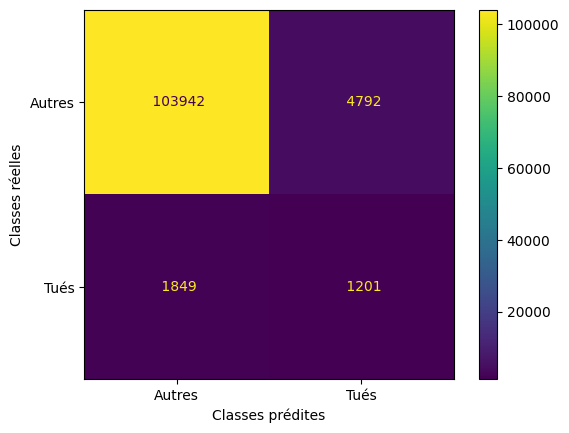

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y__test_pred)
disp = ConfusionMatrixDisplay.from_estimator(
        rf_tues_model,
        X_test_rf,
        y_test,
        display_labels=['Autres','Tués'],
        values_format=' '
    )
disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
plt.grid(False)
plt.savefig('../../../data/img/'+ 'rf_binaire_tuesvsautres_confusion_matrix' + '.png')

### Feature importance

In [231]:
importances_best_model = pd.DataFrame({'feature':X_train_rf.columns,'importance':np.round(best_model.feature_importances_,3)})
importances_best_model = importances_best_model.sort_values('importance',ascending=False).set_index('feature')
importances_best_model.head(38)

,importance
feature,
age_usager,0.106
lat,0.082
eq_ceinture,0.074
agg,0.074
long,0.072
col,0.066
catr,0.053
heure,0.047
obs,0.047


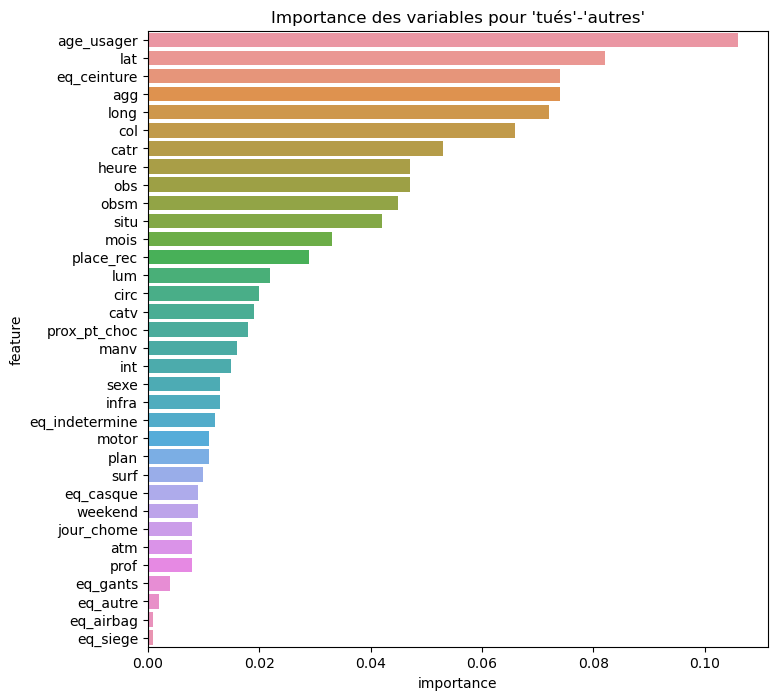

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8, 8))
sns.barplot(y = importances_best_model.index, x = importances_best_model['importance'])
plt.title("Importance des variables pour 'tués'-'autres'")
plt.show()

### Interprétation avec SHAP

In [13]:
import shap

explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test_rf)

print('Expected Value:', explainer.expected_value)


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Expected Value: [0.66443978 0.33556022]


In [14]:
print(shap_values.shape)
print(type(shap_values))
print(shap_values[0].shape)
print(shap_values[1].shape)

(111784, 34, 2)
<class 'numpy.ndarray'>
(34, 2)
(34, 2)


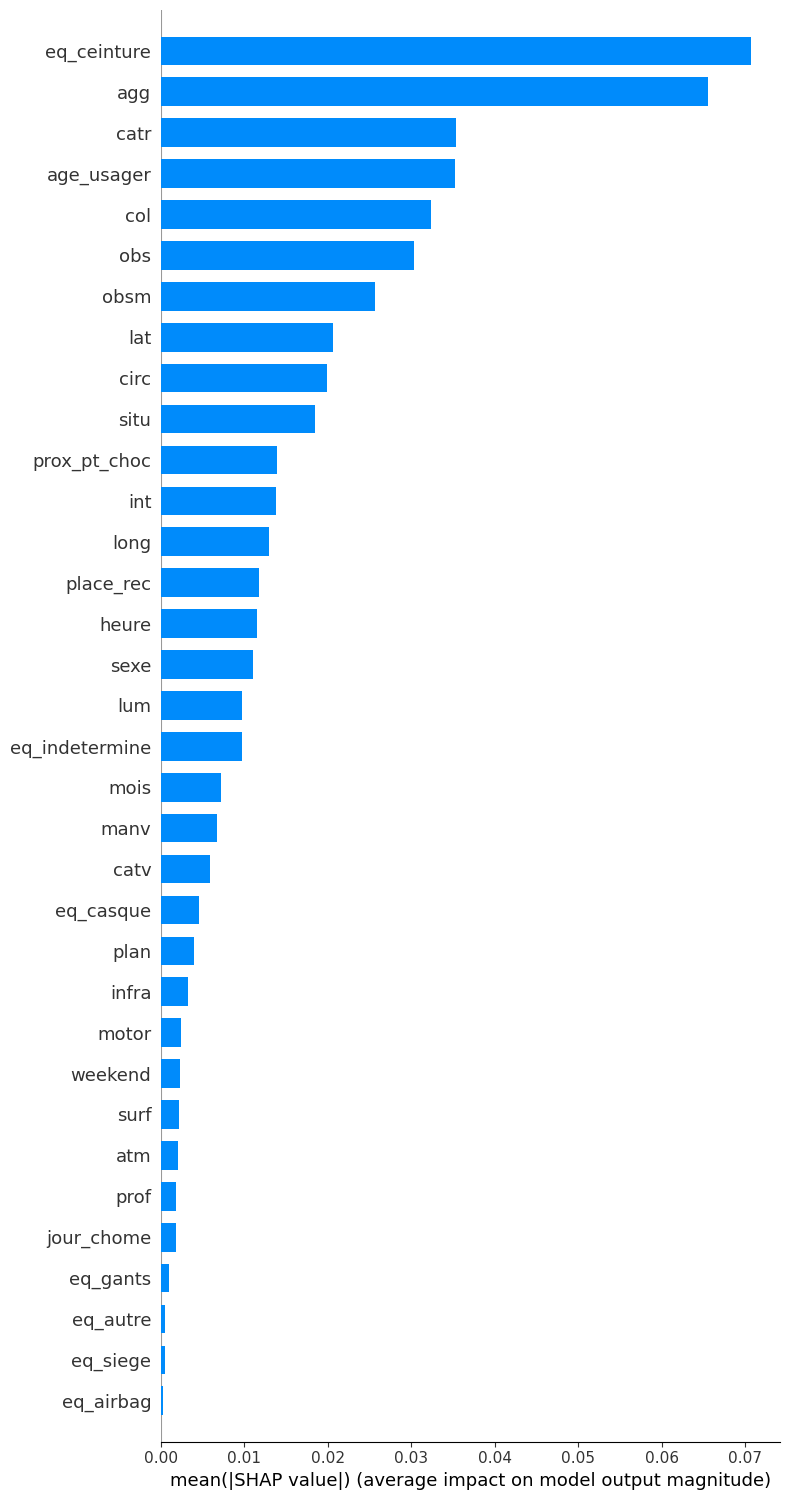

In [15]:
# Pour la classe 'autres'
shap.summary_plot(shap_values[:, :, 0], X_test_rf, plot_type="bar", max_display = len(X_test_rf))

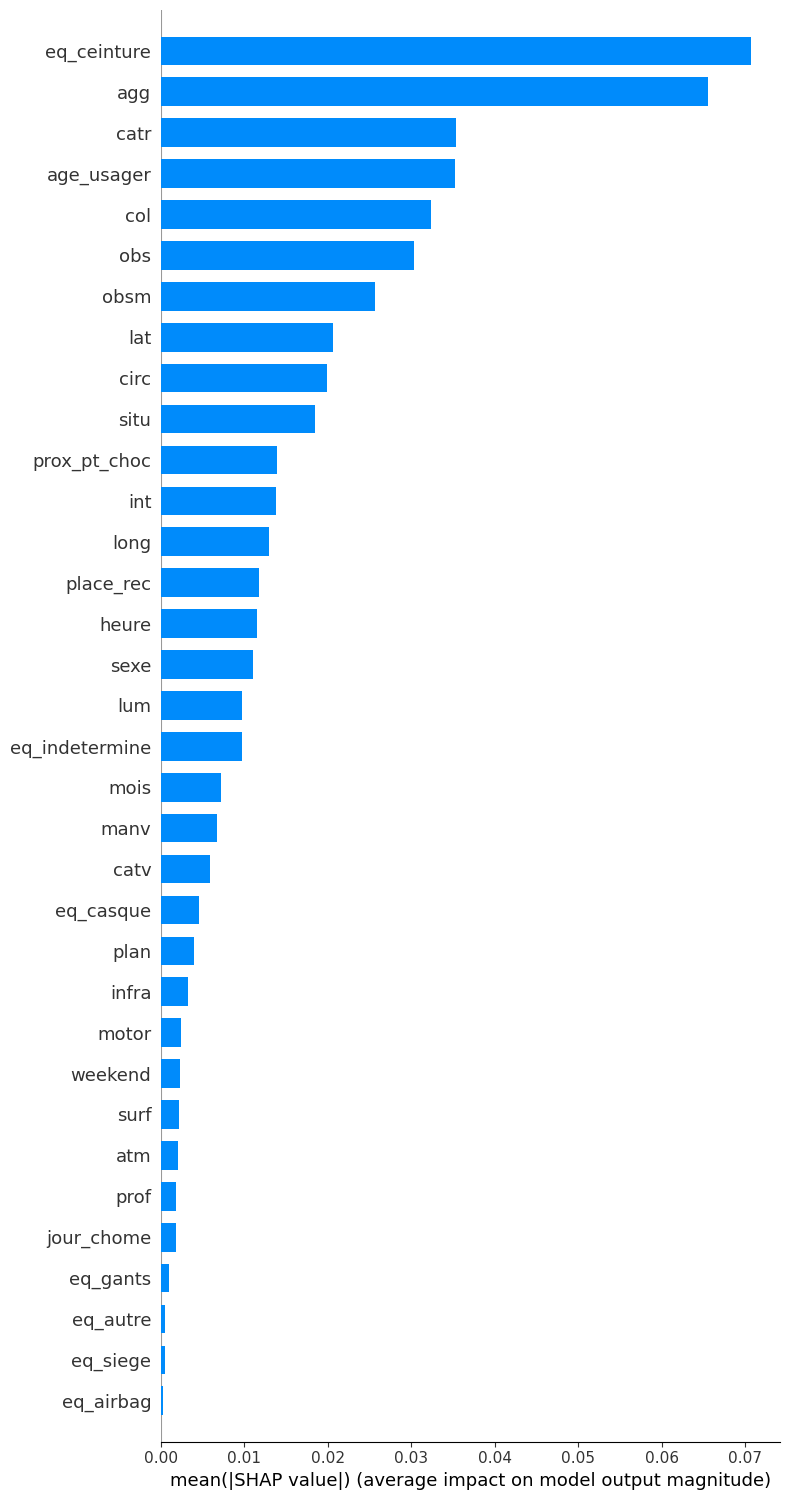

In [16]:
# Pour la classe 'tués'
shap.summary_plot(shap_values[:, :, 1], X_test_rf, plot_type="bar", max_display = len(X_test_rf))

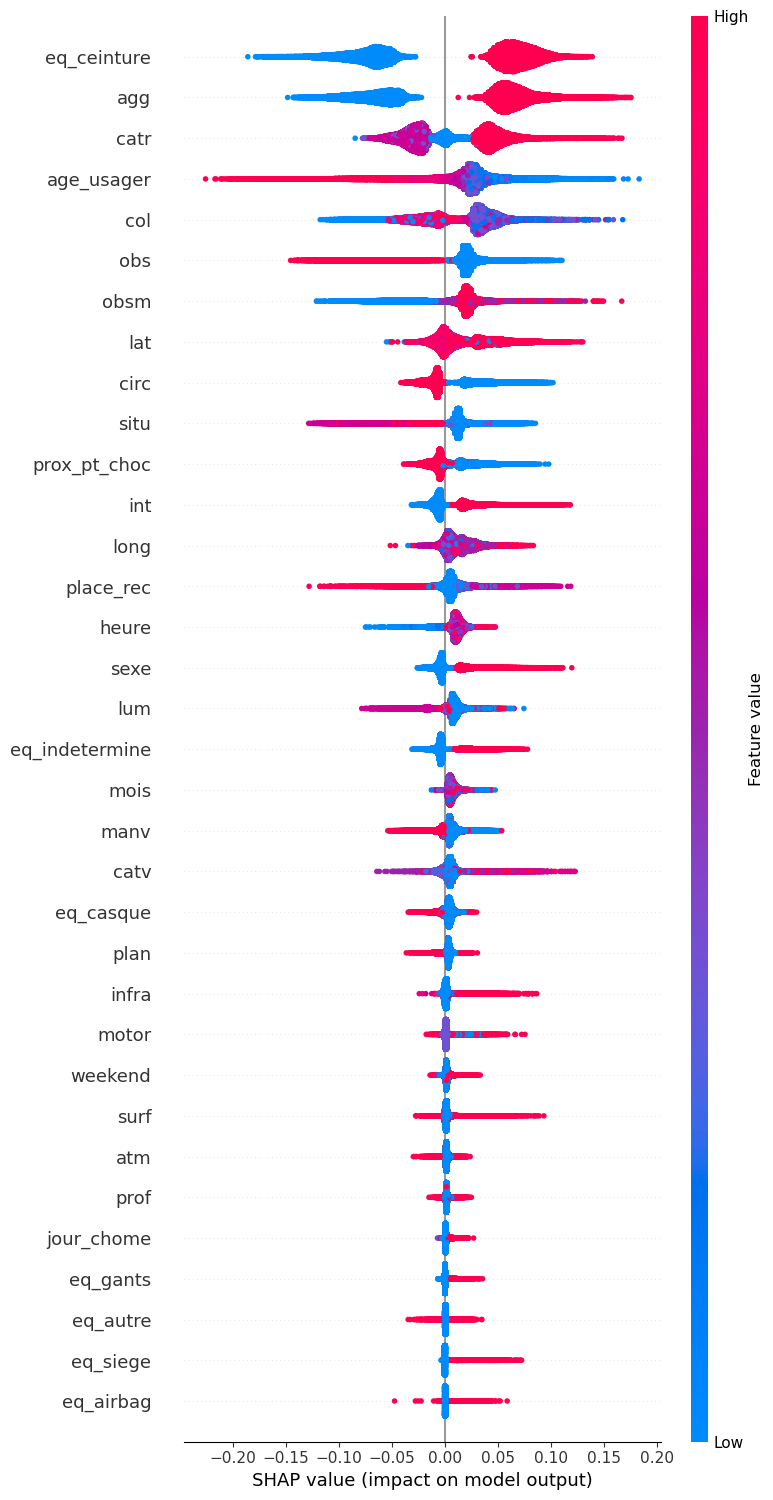

In [17]:
# Pour les 'autres'
shap.summary_plot(shap_values[:, :, 0], X_test_rf, max_display = len(X_test_rf))

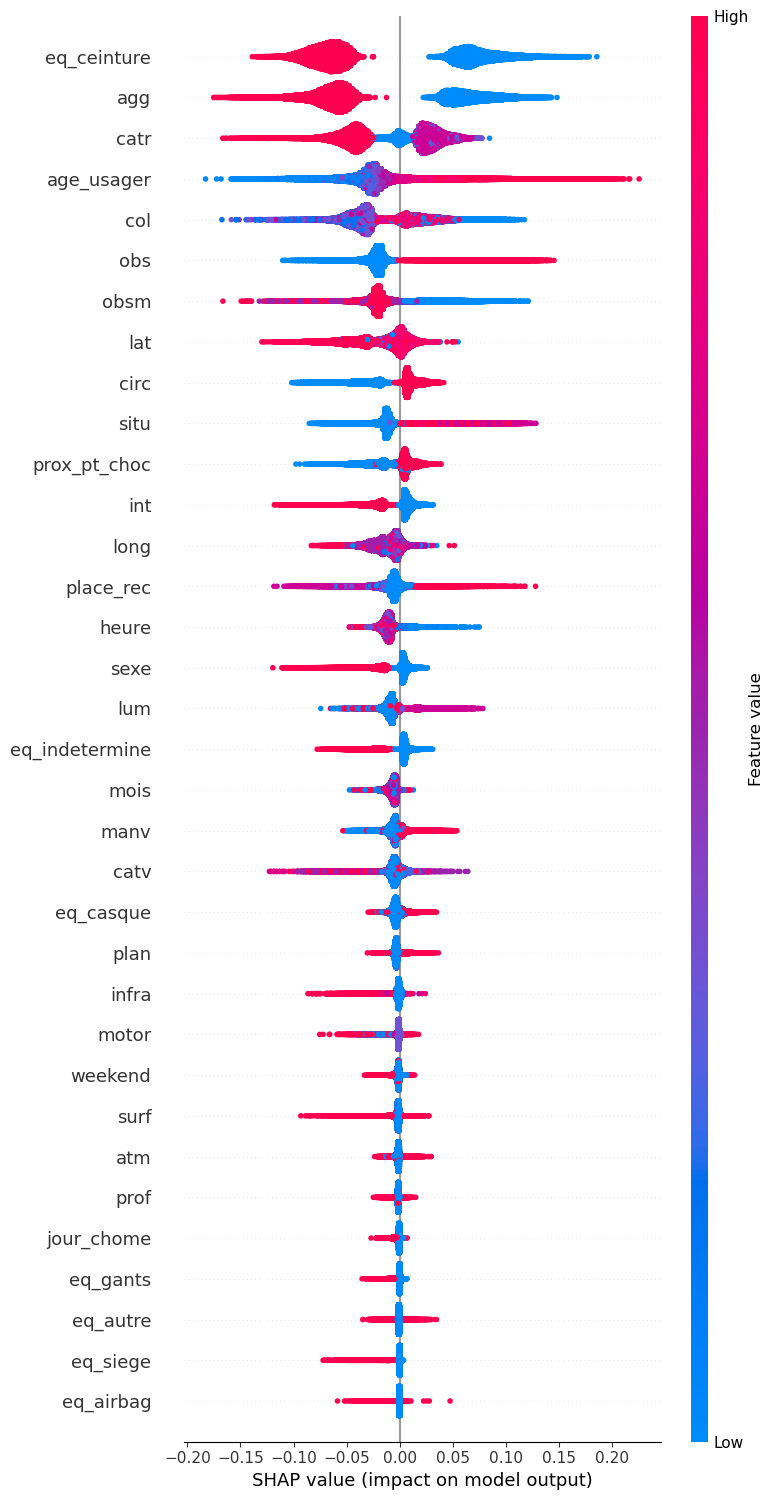

In [18]:
# Pour les 'tués'
shap.summary_plot(shap_values[:, :, 1], X_test_rf, max_display = len(X_test_rf))

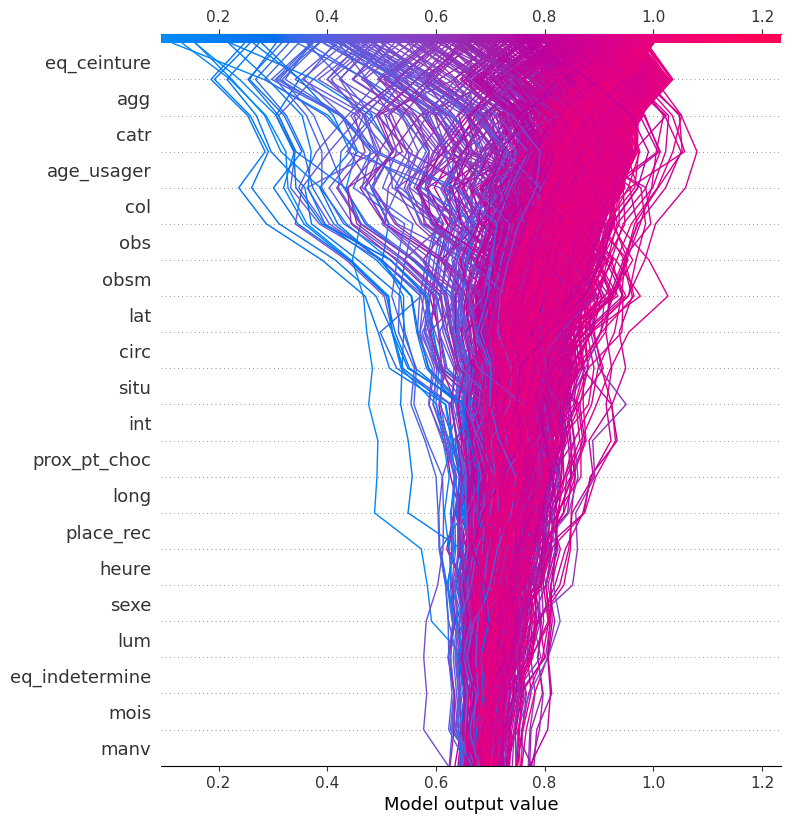

In [290]:
# détermination des variables qui contribuent au label '0'
shap.decision_plot(explainer.expected_value[0], shap_values[0:1000, :, 0], X_test_rf.columns)

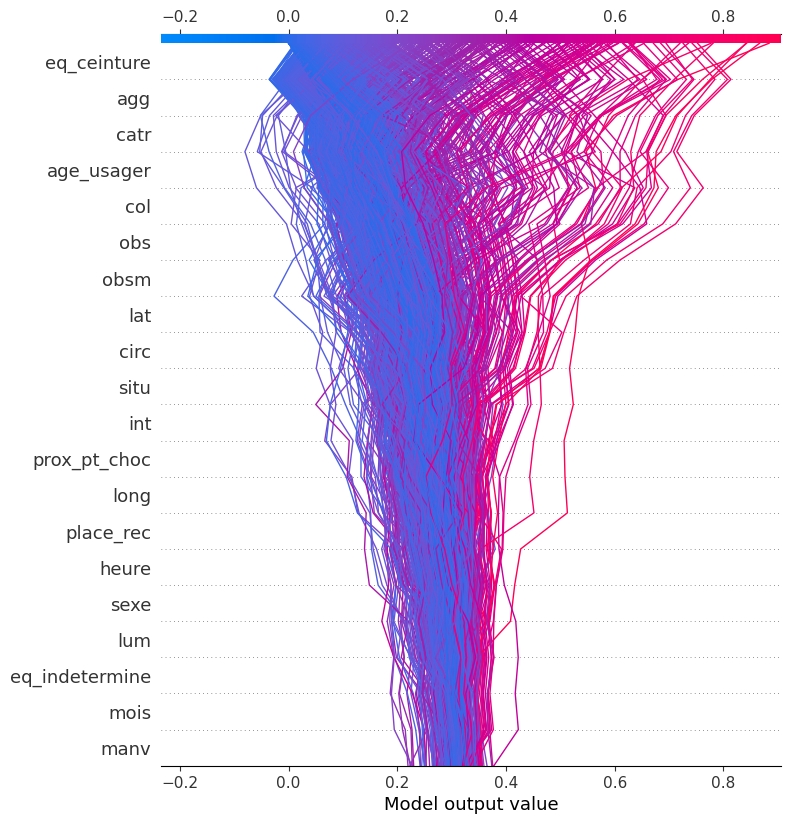

In [293]:
# détermination des variables qui contribuent au label '1'
shap.decision_plot(explainer.expected_value[1], shap_values[0:1000, :, 1], X_test_rf.columns)

# Améliorations du modèle avec monotonic_cts

In [12]:
weight = pd.DataFrame(X_test_rf.columns, columns = ['features'])
weight['weight'] = 0

In [19]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[i]= mono
        
        best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = {0: 1, 1: 18}, 
                                    criterion = 'entropy', 
                                    max_depth = 15, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
        y_train_pred = best_model.predict(X_train_rf)
        y_test_pred = best_model.predict(X_test_rf)
        
        train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
        test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
        f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
        f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
        index_list.append(i)
        features_list.append(weight.loc[i]['features'])
        weight_list.append(mono)
        train_accuracy_list.append(train_accuray)
        test_accuracy_list.append(test_accuracy)
        f1_score_0_list.append(f1_scores[0])
        f1_score_1_list.append(f1_scores[1])
        f1_macro_list.append(f1_macros)

In [20]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 24.5].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
56,28,circ,-1,95.58,94.06,96.90,26.56,61.73
6,3,heure,-1,95.08,93.75,96.73,26.44,61.59
1,0,age_usager,1,94.60,93.50,96.60,26.16,61.38
15,7,lum,1,95.31,93.83,96.78,25.96,61.37
33,16,motor,1,95.38,93.87,96.80,25.93,61.37
60,30,eq_gants,-1,95.28,93.75,96.74,25.96,61.35
58,29,eq_casque,-1,95.30,93.73,96.73,25.90,61.31
26,13,surf,-1,95.19,93.68,96.70,25.91,61.31
35,17,jour_chome,1,95.41,93.89,96.81,25.78,61.30
24,12,infra,-1,95.11,93.59,96.65,25.94,61.30


In [21]:
index_list = []
features_list = []
weight_list = []
train_accuracy_list = []
test_accuracy_list = []
f1_score_0_list = []
f1_score_1_list = []
f1_macro_list = []
j = 28

for i in range(len(X_test_rf.columns)):
    for mono in [-1, 1]:
        weight['weight'] = 0
        weight["weight"].values[j] = -1
        if (i != j):
            weight["weight"].values[i]= mono
        
            best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = {0: 1, 1: 18}, 
                                    criterion = 'entropy', 
                                    max_depth = 15, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)
        
            y_train_pred = best_model.predict(X_train_rf)
            y_test_pred = best_model.predict(X_test_rf)
        
            train_accuray = np.round(accuracy_score(y_train, y_train_pred) * 100, 2)
            test_accuracy = np.round(accuracy_score(y_test, y_test_pred) * 100, 2)
            f1_scores = np.round(f1_score(y_test, y_test_pred, average = None) * 100, 2)
            f1_macros = np.round(f1_score(y_test, y_test_pred, average = 'macro') * 100, 2)
        
            index_list.append(i)
            features_list.append(weight.loc[i]['features'])
            weight_list.append(mono)
            train_accuracy_list.append(train_accuray)
            test_accuracy_list.append(test_accuracy)
            f1_score_0_list.append(f1_scores[0])
            f1_score_1_list.append(f1_scores[1])
            f1_macro_list.append(f1_macros)

In [22]:
dico = {'index' : index_list,
        'features' : features_list,
        'weight' : weight_list,
        'train_accuracy' : train_accuracy_list,
        'test_accuracy' : test_accuracy_list,
        'f1_score_0' : f1_score_0_list,
        'f1_score_1' : f1_score_1_list,
        'f1_macro' : f1_macro_list}

results = pd.DataFrame(dico, columns = ['index', 'features', 'weight', 'train_accuracy', 'test_accuracy', 'f1_score_0', 'f1_score_1', 'f1_macro'])
results = results[results['f1_score_1'] > 24.5].sort_values('f1_macro', ascending = False)
results[:10]

,index,features,weight,train_accuracy,test_accuracy,f1_score_0,f1_score_1,f1_macro
25,12,infra,1,95.63,94.10,96.93,26.32,61.62
20,10,situ,-1,95.45,93.93,96.83,26.37,61.60
23,11,weekend,1,95.44,93.96,96.85,26.27,61.56
62,32,eq_airbag,-1,95.64,94.10,96.93,26.19,61.56
54,27,prox_pt_choc,-1,95.62,94.03,96.89,26.19,61.54
58,30,eq_gants,-1,95.42,93.89,96.82,26.24,61.53
65,33,eq_siege,1,95.63,94.05,96.90,26.16,61.53
3,1,lat,1,95.12,93.84,96.78,26.23,61.51
30,15,plan,-1,95.46,93.91,96.82,26.15,61.49
26,13,surf,-1,95.51,93.93,96.83,26.12,61.48


On s'arrête ici pour les ajustement car le f1_macro diminue. On a ajusté la variables 'circ'

In [13]:
weight['weight'] = 0
weight["weight"].values[28] = -1

best_model = RandomForestClassifier(bootstrap = True, 
                                    class_weight = {0: 1, 1: 18}, 
                                    criterion = 'entropy', 
                                    max_depth = 15, 
                                    min_samples_leaf = 1, 
                                    min_samples_split = 2, 
                                    n_estimators = 100, 
                                    n_jobs = -1, 
                                    random_state = 42,
                                    monotonic_cst = weight['weight']).fit(X_train_rf, y_train)

y_train_pred = best_model.predict(X_train_rf)
y_test_pred = best_model.predict(X_test_rf)
print("Train acuracy :", np.round(accuracy_score(y_train, y_train_pred) * 100, 2), "%")
print("Test acuracy : ", np.round(accuracy_score(y_test, y_test_pred) * 100, 2), "%")
print()

print("Matrice de confusion :")
display(pd.crosstab(y_test, y_test_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))
print()
print("Rapport de classification :\n", classification_report(y_test, y_test_pred))

Train acuracy : 95.58 %
Test acuracy :  94.06 %

Matrice de confusion :


Classes prédites,0,1
Classes réelles,,
0,103942,4792
1,1849,1201



Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    108734
           1       0.20      0.39      0.27      3050

    accuracy                           0.94    111784
   macro avg       0.59      0.67      0.62    111784
weighted avg       0.96      0.94      0.95    111784



In [14]:
joblib.dump(best_model, "../../../data/saved_models/RandomForest_2classes_tues_autres.joblib")

['../../../data/saved_models/RandomForest_2classes_tues_autres.joblib']